In [1]:
from __future__ import print_function
import theano
import theano.tensor as T
import numpy as np
import lasagne
import math
import matplotlib.pyplot as plt
from IPython import display
import random
import scipy
import json

In [2]:
%matplotlib inline

In [3]:
class GCNLayer(lasagne.layers.Layer):
    def __init__(
        self, incoming, A_hat, num_out_features=3,
        W=lasagne.init.GlorotUniform(),
        nonlinearity=lasagne.nonlinearities.sigmoid,
        **kwargs
    ):
        
        super(GCNLayer, self).__init__(incoming, **kwargs)
        self.A_hat = A_hat
        self.num_out_features = num_out_features
        if nonlinearity is None:
            nonlinearity = lasagne.nonlinearities.linear
        self.nonlinearity = nonlinearity
        
        self.W = self.add_param(W, [incoming.output_shape[2], num_out_features], name="W")
        
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1], self.num_out_features)
    
    def get_output_for(self, input, **kwargs):
        A_X = T.tensordot(self.A_hat, input, axes=[1, 1]).transpose(1, 0, 2)
        Z = T.dot(A_X, self.W)
        return self.nonlinearity(Z)
    
class GCNLayer(lasagne.layers.Layer):
    def __init__(
        self, incoming, A_hat, num_out_features=3, num_graphs=2,
        W=lasagne.init.GlorotUniform(),
        nonlinearity=lasagne.nonlinearities.sigmoid,
        **kwargs
    ):
        
        super(GCNLayer, self).__init__(incoming, **kwargs)
        self.A_hat = A_hat
        self.num_graphs = num_graphs
        self.num_out_features = num_out_features
        if nonlinearity is None:
            nonlinearity = lasagne.nonlinearities.linear
        self.nonlinearity = nonlinearity
        
        # print([self.num_graphs, incoming.output_shape[2], num_out_features])
        self.W = self.add_param(W, [self.num_graphs, incoming.output_shape[2], num_out_features], name="W")
        
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1], self.num_out_features)
    
    def get_output_for(self, input, **kwargs):
        A_X = T.tensordot(self.A_hat, input, axes=[1, 1]).transpose(2, 1, 0, 3)
        Z = T.tensordot(A_X, self.W, axes=2)
        return self.nonlinearity(Z)
    
def special_softmax(t):
    #num = T.exp(t)
    #den = num.sum(2, keepdims=True)
    #return num / den
    t2 = t.reshape((-1, t.shape[-1]))
    t2 = lasagne.nonlinearities.softmax(t2)
    return t2.reshape(t.shape)

class ConfusionMatrix(object):
    def __init__(self, preds, reals):
        assert len(preds) == len(reals)
        self.preds = preds
        self.reals = reals
        classes = sorted(set(preds) | set(reals))
        mat = np.zeros([len(classes), len(classes)], dtype="int")
        for real, pred in zip(reals, preds):
            mat[classes.index(real), classes.index(pred)] += 1
        self.mat = mat     
            
    def __str__(self):
        return str(self.mat)
    
    def bac(self):
        return (self.mat.diagonal() / self.mat.sum(1)).mean()

In [4]:
with open("../Data/aa_indices.json") as f:
    aa_indices = json.load(f)
del aa_indices["cysteine"]

In [5]:
changes_dict = {}
for aa, idx in aa_indices.items():
    changes_dict[aa] = round(cat_Y[:, idx, 0].sum()/cat_Y.shape[0], 2)
for aa in sorted(changes_dict, key=lambda x: changes_dict[x]):
    print(aa, changes_dict[aa])

NameError: name 'cat_Y' is not defined

In [6]:
aa = "valine"

In [11]:
loaded = np.load("../Data/NN_data.npz")
data = dict(zip(loaded["arr_1"], loaded["arr_0"]))
X = data["X"].astype("float32")
Y = data["Y"].astype("float32")
weight_mask = data["weight_mask"]
cat_Y = data["cat_Y"].astype("float32")
affected = data["affected"].astype("bool")

splitpoint = 75

X = X[affected]
Y = Y[affected]
cat_Y = cat_Y[affected]


order = random.sample(range(len(X)), len(X))
X = X[order]
Y = Y[order]
cat_Y = cat_Y[order]

# Merge increase and decrease
cat_Y = np.stack([cat_Y[:, :, 1], cat_Y[:, :, 0] + cat_Y[:, :, 2]], axis=2)

# Only predict one metabolite
aa_mask = np.zeros_like(Y)
aa_mask[:, aa_indices[aa]] = 1
Y = Y * aa_mask

mask = (Y != 0).astype("float")
cat_Y = cat_Y * mask

covariates = Y.copy()
covariates[:, aa_indices[aa]] = 0
X = np.concatenate([X, covariates], axis=2)


#mask[:, :, 0] = mask[:, :, 0] / ((cat_Y[:, :, 1] == 1).astype("float") * 3 + 1)

#mask = np.stack([weight_mask]).transpose([1, 2, 0])
#mask = mask * np.abs(Y)
#mask = np.zeros_like(Y, dtype="int32")
#mask[:, 256] = 1
A_hat = data["A_hat"].astype("float32")
A_hat_2 = data["double_A"].astype("float32")

Y = cat_Y
#for i, fact in enumerate(cat_factors):
#    mask[:, :, 0] *= (cat_Y[:, :, i] == 1).astype("int") * (fact - 1) + 1

# Amplify knockout signal
X[:, :, 0] *= 1000

X_train = X[:splitpoint]
Y_train = Y[:splitpoint]
X_test = X[splitpoint:]
Y_test = Y[splitpoint:]

mask_train = mask[:splitpoint]
mask_test = mask[splitpoint:]

cat_counts = Y.sum(1).sum(0)
cat_factors = [cat_counts.max() / cnt for cnt in cat_counts]
print(cat_counts)

train_cat_counts = Y_train.sum(1).sum(0)
train_cat_factors = [train_cat_counts.max() / cnt for cnt in train_cat_counts]
print(train_cat_counts)
print(np.array(cat_counts) - np.array(train_cat_counts))

for i, fact in enumerate(train_cat_factors):
    mask_train[:, :, 0] *= (Y_train[:, :, i] == 1).astype("int") * (fact - 1) + 1

(111, 2803, 1)
[ 71.  40.]
[ 49.  26.]
[ 22.  14.]


In [12]:
Y_train.shape

(75, 2803, 2)

In [13]:
mask_train.shape

(75, 2803, 1)

In [14]:
X_train = X_train["valine"]
Y_train = Y_train["valine"]
mask_train = mask_train["valine"]

X_test = X_test["valine"]
Y_test = Y_test["valine"]
mask_test = mask_test["valine"]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [15]:
train_cat_factors

[1.0, 1.8846153846153846]

In [16]:
X.shape

(111, 2803, 5)

In [17]:
Y_test.max()

1.0

In [18]:
BATCH_SIZE = 100
NUM_INPUTS = X_train.shape[2]
NUM_OUTPUTS = Y.shape[-1]

x_sym = T.tensor3("x_sym")
y_sym = T.tensor3("y_sym")
#A_sym = T.matrix("A_sym")
A_sym = T.tensor3("A_sym")
ymask_sym = T.tensor3("ymask_sym")

l_in = lasagne.layers.InputLayer((None, A_hat.shape[0], NUM_INPUTS))

l_1 = GCNLayer(l_in, A_sym, num_out_features=3, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 5
l_2 = GCNLayer(l_1, A_sym, num_out_features=5, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 7
l_3 = GCNLayer(l_2, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 9
l_4 = GCNLayer(l_3, A_sym, num_out_features=9, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 13
l_5 = GCNLayer(l_4, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify)

l_concat = lasagne.layers.ConcatLayer([l_1, l_2, l_3, l_4], axis=2)

# Dense: 50 units, leaky_rectify
l_slice = lasagne.layers.SliceLayer(l_concat, indices=aa_indices[aa], axis=1)
l_dense = lasagne.layers.DenseLayer(l_slice, num_units=30, num_leading_axes=1, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_drop = lasagne.layers.DropoutLayer(l_dense)

l_out = lasagne.layers.DenseLayer(l_drop, num_units=NUM_OUTPUTS, num_leading_axes=1, nonlinearity=special_softmax)


all_params = lasagne.layers.get_all_params(l_out, trainable=True)
print(sum(w.eval().size for w in all_params), "parameters")

1068 parameters


In [19]:
#theano.config.exception_verbosity = "high"

In [20]:
print("Input layer", lasagne.layers.get_output(l_in, inputs={l_in: x_sym}).eval({x_sym: X}).shape)

print("Conv layer", lasagne.layers.get_output(l_1, inputs={l_in: x_sym}).eval({x_sym: X, A_sym: A_hat_2}).shape)

print("Conv layer", lasagne.layers.get_output(l_2, inputs={l_in: x_sym}).eval({x_sym: X, A_sym: A_hat_2}).shape)

print("Output layer", lasagne.layers.get_output(l_out, inputs={l_in: x_sym}).eval({x_sym: X, A_sym: A_hat_2}).shape)

Input layer (111, 2803, 5)
Conv layer (111, 2803, 3)
Conv layer (111, 2803, 5)
Output layer (111, 2)


In [21]:
A_hat_2.shape

(2, 2803, 2803)

In [538]:
# Retrieve network output
train_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=False)
eval_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=True)

all_params = lasagne.layers.get_all_params(l_out, trainable=True)

# cost = T.nnet.categorical_crossentropy(train_out+1e-8, y_sym).mean()
# cost = lasagne.objectives.squared_error(train_out, y_sym)
cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym[:, aa_indices[aa]])
cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, aa_indices[aa], 0], mode="mean")

# cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym)
# cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, :, 0], mode="mean")

#cost_eval = lasagne.objectives.squared_error(eval_out, y_sym)

all_grads = T.grad(cost, all_params)

updates = lasagne.updates.adamax(all_grads, all_params, learning_rate=0.06)#, learning_rate=0.002) #, learning_rate=0.002)

f_eval = theano.function([x_sym, A_sym],
                     eval_out, on_unused_input='warn')

cost_eval = theano.function([x_sym, y_sym, A_sym, ymask_sym],
                     cost, on_unused_input='warn')

f_train = theano.function(
    [x_sym, y_sym, A_sym, ymask_sym],
    cost,
    updates=updates, on_unused_input='warn'
)

In [539]:
EPOCHS = 50
BATCH_SIZE = 10

train_losses = []
test_losses = []

best_bac = 0

for epoch in range(EPOCHS):
    for j in range(1):
        for i in range(math.ceil(len(X_train)/BATCH_SIZE)):
            x_batch = X_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            y_batch = Y_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            mask_batch = mask_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]

            #f_train({x_sym: x_batch, y_sym: y_batch, A_sym: A_hat, ymask_sym: mask_batch})
            if epoch != 0:
                batch_train_loss = f_train(x_batch, y_batch, A_hat_2, mask_batch)
        
    test_output = f_eval(X_test, A_hat_2)
    train_output = f_eval(X_train, A_hat_2)
    
    test_loss = cost_eval(X_test, Y_test, A_hat_2, mask_test)
    train_loss = cost_eval(X_train, Y_train, A_hat_2, mask_train)
    #test_loss = (lasagne.objectives.categorical_crossentropy(test_output+1e-8, Y_test) * mask_test[:, :, 0]).sum() / mask_test.sum()
    #train_loss = 0.5 * (lasagne.objectives.categorical_crossentropy(train_output+1e-8, Y_train) * mask_train[:, :, 0]).sum() / mask_test.sum()
    
    #print((test_cost * mask_test).mean())
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    plt.figure(figsize=[14, 5])
    plt.subplot(1, 3, 1)
    plt.plot(list(range(epoch+1)), train_losses, "g", label="Train")
    plt.plot(list(range(epoch+1)), test_losses, "b", label="Test")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    
    
    plt.savefig("out.png")
    plt.close()
    display.display(display.Image(filename="out.png"))
    test_predictions = test_output.argmax(-1)#.flatten()[mask_test.flatten().astype("bool")]
    real_classes = Y_test.argmax(-1)[:, aa_indices[aa]]#.flatten()[mask_test.flatten().astype("bool")]
    # test_predictions = test_output.argmax(-1).flatten()[mask_test.flatten().astype("bool")]
    # real_classes = Y_test.argmax(-1).flatten()[mask_test.flatten().astype("bool")]
    
    conf = ConfusionMatrix(test_predictions, real_classes)
    print(conf)
    print(conf.bac())
    print("")
    if conf.bac() > best_bac:
        best_bac = conf.bac()
        best_pred = test_predictions
        best_output = test_output
        real_test_classes = real_classes
        best_epoch = epoch
    
    test_predictions = train_output.argmax(-1)#.flatten()[mask_train.flatten().astype("bool")]
    real_classes = Y_train.argmax(-1)[:, aa_indices[aa]]#.flatten()[mask_train.flatten().astype("bool")]
    # test_predictions = train_output.argmax(-1).flatten()[mask_train.flatten().astype("bool")]
    # real_classes = Y_train.argmax(-1).flatten()[mask_train.flatten().astype("bool")]
    
    conf = ConfusionMatrix(test_predictions, real_classes)
    print(conf)
    print(conf.bac())
    
    print(epoch)
    
    display.clear_output(wait=True)

KeyboardInterrupt: 

In [544]:
x_batch

18.039053

In [393]:
print(ConfusionMatrix(best_pred, Y_test.argmax(-1).flatten()[mask_test.flatten().astype("bool")]))

[[20  4]
 [ 5  7]]


In [73]:
lasagne.objectives.categorical_crossentropy(test_output, Y_test).eval().shape

(31, 2803)

In [74]:
mask_test.shape

(31, 2803, 1)

In [ ]:
# pFBA fluxes: Much less overfitting (train_loss < test_loss) than with model.solve() fluxes :S

In [221]:
correctness = Y_test.argmax(2) == test_output.argmax(2)
train_correctness = Y_train.argmax(2) == train_output.argmax(2)

In [222]:
node_mask = (mask_test != 0)[0, :, 0]

In [223]:
aa_order = [
    'alanine',
    'arginine',
    'asparagine',
    'aspartate',
    'glutamine',
    'glutamate',
    'glycine',
    'histidine',
    'isoleucine',
    'leucine',
    'lysine',
    'methionine',
    'phenylalanine',
    'proline',
    'serine',
    'threonine',
    'tryptophan',
    'tyrosine',
    'valine'
]

In [16]:
correctness.shape

(31, 2803)

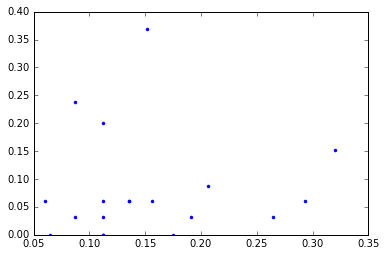

In [17]:
plt.plot(Y_test.argmax(2)[:, node_mask].var(0),
        test_output.argmax(2)[:, node_mask].var(0), ".")

In [224]:
def prediction_plots():
    node_mask = (mask_test != 0)[0, :, 0]
    
    fig = plt.figure(figsize=[14, 14])
    
    guess = np.ones_like(test_output)
    
    correctness = (Y_test.argmax(2) == test_output.argmax(2))[:, node_mask]
    #correctness = (Y_test.argmax(2) == guess[:, :, 0])[:, node_mask]
    train_correctness = (Y_train.argmax(2) == train_output.argmax(2))[:, node_mask]
    
    # Bar chart
    aa_accuracies = correctness.astype("int").mean(0)
    ax = fig.add_subplot(2, 2, 1)
    ax.plot([-1, 19], [1/3, 1/3], "--r")
    plt.bar(np.arange(0, len(aa_accuracies))-0.5, aa_accuracies)
    plt.xlim(-1, 19)
    plt.xticks(range(len(aa_accuracies)), rotation="vertical")
    ax.set_xticklabels(aa_order)
    
    plt.ylabel("Acc")
    
    # Var vs Acc
    ax = fig.add_subplot(2, 2, 2)
    var = Y_test[:, node_mask].argmax(2).var(0)
    
    plt.plot(var, aa_accuracies, ".")
    plt.plot([var.min(), var.max()], [1/3, 1/3], "--r")
    
    plt.ylim([0, 1])
    
    plt.xlabel("Variance")
    plt.ylabel("Acc")
    
    # Highest class frequency vs accuracy
    ax = fig.add_subplot(2, 2, 3)
    top_freq = Y_train[:, node_mask].sum(0).max(1) / Y_train.shape[0]
    
    plt.plot(top_freq, aa_accuracies, ".")
    plt.plot([top_freq.min(), top_freq.max()], [top_freq.min(), top_freq.max()], "r--")
    
    plt.xlabel("Freq of most frequent class")
    plt.ylabel("Acc")

In [61]:
bacs = np.zeros([len(aa_order), 3])
for i in range(3):
    bacs[:, i] = (train_correctness[:, node_mask] & (Y_train[:, node_mask].argmax(2) == i)).sum(0)
    

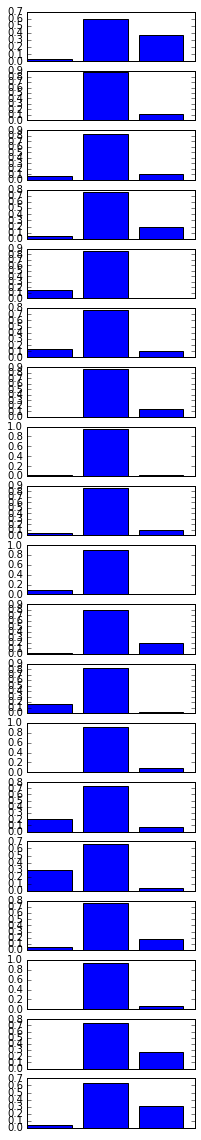

In [63]:
plt.figure(figsize=[3, 20])
freqs = Y[:, node_mask].sum(0) / Y.shape[0]
for i, aa in enumerate(aa_order):
    plt.subplot(19, 1, i+1)
    
    plt.bar(np.arange(0, 3, 1), freqs[i])
    plt.xticks([])
    

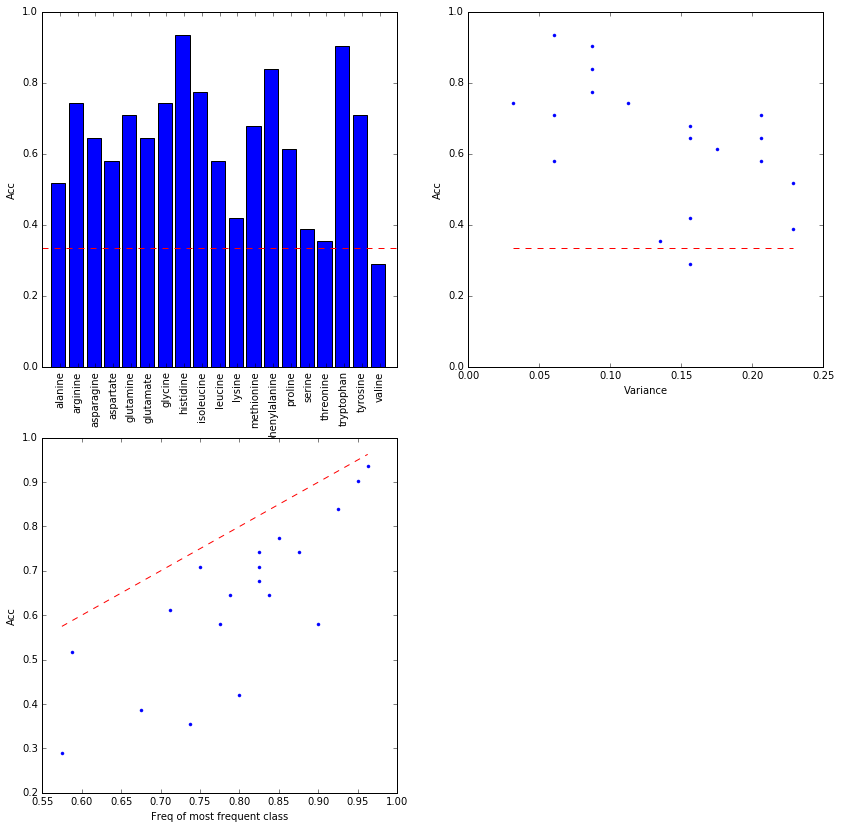

In [225]:
prediction_plots()

In [38]:
(test_output[:, node_mask].argmax(2) == 2).sum()

641

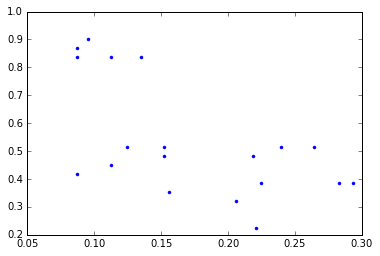

In [18]:
plt.plot(Y_test.argmax(2)[:, node_mask].var(0),
            (correctness * (mask_test != 0).astype("int")[:, :, 0]).mean(0)[node_mask], ".")

In [92]:
(correctness * (mask_test != 0).astype("int")[:, :, 0]).mean(0)[node_mask]

array([ 0.41935484,  0.22580645,  0.41935484,  0.25806452,  0.35483871,
        0.29032258,  0.80645161,  0.90322581,  0.74193548,  0.48387097,
        0.64516129,  0.25806452,  0.74193548,  0.32258065,  0.38709677,
        0.22580645,  0.70967742,  0.29032258,  0.19354839])

In [59]:
test_output.shape

(31, 2803, 3)

Necessary?: Flux coupling, fluxes, specific knock-out fluxes?
Generative??
What does it fail at predicting?
Take another look at Uwe paper

In [562]:
loaded = np.load("../Data/NN_data.npz")

data = dict(zip(loaded["arr_1"], loaded["arr_0"]))
X = data["X"].astype("float32")
Y = data["Y"].astype("float32")
weight_mask = data["weight_mask"]
cat_Y = data["cat_Y"].astype("float32")
affected = data["affected"].astype("bool")

splitpoint = 75
X = X[affected]
Y = Y[affected]
cat_Y = cat_Y[affected]

order = random.sample(range(len(X)), len(X))
X = X[order]
Y = Y[order]
cat_Y = cat_Y[order]

# Merge increase and decrease
cat_Y = np.stack([cat_Y[:, :, 1], cat_Y[:, :, 0] + cat_Y[:, :, 2]], axis=2)

for aa, idx in aa_indices.items():
    print("%2s" % int(cat_Y[:splitpoint, idx, 1].sum()), end="  ")

print("")
    
for aa, idx in aa_indices.items():
    print("%2s" % int(cat_Y[splitpoint:, idx, 1].sum()), end="  ")
print("")

13  31   4  22   5  17   9  11  20  12  31  16  10   7  17   8  19  28  12  
 7   9   1   8   2  10   5   5   9   3  13   6   5   3   9   1   7   9   7  


In [559]:
# np.savez("../Data/Permuted_data1.npz", X=X, Y=Y, cat_Y=cat_Y)

In [556]:
# Train on all aa's simultaneously. Predict conc changes from all other concs and gene KO.
# All aa's have same GCN layer parameters, and individual dense layers

loaded = np.load("../Data/Permuted_data1.npz")

splitpoint = 75

X_train = {}
Y_train = {}
mask_train = {}

X_test = {}
Y_test = {}
mask_test = {}

for aa, idx in aa_indices.items():
    
    X = loaded["X"]
    Y = loaded["Y"]
    cat_Y = loaded["cat_Y"]
    covariates = Y.copy()
    
    # Only predict one metabolite
    aa_mask = np.zeros_like(Y)
    aa_mask[:, aa_indices[aa]] = 1
    Y = Y * aa_mask
    
    mask = (Y != 0).astype("float")
    cat_Y = cat_Y * mask

    covariates[:, aa_indices[aa]] = 0
    X = np.concatenate([X, covariates], axis=2)
    
    # Amplify knockout signal
    X[:, :, 0] *= 3000
    
    Y = cat_Y
    
    X_train[aa] = X[:splitpoint]
    Y_train[aa] = Y[:splitpoint]
    X_test[aa] = X[splitpoint:]
    Y_test[aa] = Y[splitpoint:]

    mask_train[aa] = mask[:splitpoint]
    mask_test[aa] = mask[splitpoint:]
    
    train_cat_counts = Y_train[aa].sum(1).sum(0)
    train_cat_factors = [train_cat_counts.max() / cnt for cnt in train_cat_counts]
    #print(train_cat_counts)
    #print(np.array(cat_counts) - np.array(train_cat_counts))

    for i, fact in enumerate(train_cat_factors):
        mask_train[aa][:, :, 0] *= (Y_train[aa][:, :, i] == 1).astype("int") * (fact - 1) + 1
        
first_aa = list(aa_indices)[0]
        
NUM_INPUTS = X_train[first_aa].shape[2]
NUM_OUTPUTS = Y_train[first_aa].shape[-1]
x_sym = T.tensor3("x_sym")
y_sym = T.tensor3("y_sym")
#A_sym = T.matrix("A_sym")
A_sym = T.tensor3("A_sym")
ymask_sym = T.tensor3("ymask_sym")

l_in = lasagne.layers.InputLayer((None, A_hat.shape[0], NUM_INPUTS))
l_1 = GCNLayer(l_in, A_sym, num_out_features=5, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 5
l_2 = GCNLayer(l_1, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 7
l_3 = GCNLayer(l_2, A_sym, num_out_features=9, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 9
l_4 = GCNLayer(l_3, A_sym, num_out_features=9, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 13
l_5 = GCNLayer(l_4, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_concat = lasagne.layers.ConcatLayer([l_1, l_2, l_3, l_4, l_5], axis=2)

aa_output_layers = {}
f_train = {}
f_eval = {}
cost_eval = {}

for aa, idx in aa_indices.items():
    # if aa not in ["valine"]:
    #     continue
    print(aa)
    
    l_slice = lasagne.layers.SliceLayer(l_concat, indices=idx, axis=1)
    l_dense = lasagne.layers.DenseLayer(l_slice, num_units=30, num_leading_axes=1, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    l_drop = lasagne.layers.DropoutLayer(l_dense)

    l_out = lasagne.layers.DenseLayer(l_drop, num_units=NUM_OUTPUTS, num_leading_axes=1, nonlinearity=special_softmax)
    
    aa_output_layers[aa] = l_out
    
    # Retrieve network output
    train_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=False)
    eval_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=True)

    all_params = lasagne.layers.get_all_params(l_out, trainable=True)

    # cost = T.nnet.categorical_crossentropy(train_out+1e-8, y_sym).mean()
    # cost = lasagne.objectives.squared_error(train_out, y_sym)
    cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym[:, aa_indices[aa]])
    cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, aa_indices[aa], 0], mode="mean")

    # cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym)
    # cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, :, 0], mode="mean")

    #cost_eval = lasagne.objectives.squared_error(eval_out, y_sym)

    all_grads = T.grad(cost, all_params)

    updates = lasagne.updates.adamax(all_grads, all_params, learning_rate=0.06)#, learning_rate=0.002) #, learning_rate=0.002)

    f_eval[aa] = theano.function([x_sym, A_sym],
                         eval_out, on_unused_input='warn')

    cost_eval[aa] = theano.function([x_sym, y_sym, A_sym, ymask_sym],
                         cost, on_unused_input='warn')

    f_train[aa] = theano.function(
        [x_sym, y_sym, A_sym, ymask_sym],
        cost,
        updates=updates, on_unused_input='warn'
    )

methionine
valine
histidine
proline
tryptophan
aspartate
arginine
glutamine
tyrosine
isoleucine
alanine
lysine
glycine
leucine
glutamate
phenylalanine
threonine
serine
asparagine


In [504]:
Y_train["valine"][:, aa_indices["valine"]].sum(0)

array([ 48.,  27.])

In [531]:
all_params[0] is l_1.W

True

In [525]:
f_eval["valine"](X_train["valine"], A_hat_2)

array([[ 0.48001891,  0.51998109],
       [ 0.48001744,  0.51998256],
       [ 0.47998582,  0.52001418],
       [ 0.48001913,  0.51998087],
       [ 0.47961679,  0.52038321],
       [ 0.4800187 ,  0.5199813 ],
       [ 0.48001917,  0.51998083],
       [ 0.48001865,  0.51998135],
       [ 0.47855098,  0.52144902],
       [ 0.4800192 ,  0.5199808 ],
       [ 0.48001905,  0.51998095],
       [ 0.480019  ,  0.519981  ],
       [ 0.48001868,  0.51998132],
       [ 0.48001907,  0.51998093],
       [ 0.48001599,  0.51998401],
       [ 0.48001861,  0.51998139],
       [ 0.48001886,  0.51998114],
       [ 0.48001924,  0.51998076],
       [ 0.47891675,  0.52108325],
       [ 0.47855096,  0.52144904],
       [ 0.48001929,  0.51998071],
       [ 0.48001656,  0.51998344],
       [ 0.47855102,  0.52144898],
       [ 0.47998559,  0.52001441],
       [ 0.48001913,  0.51998087],
       [ 0.48002022,  0.51997978],
       [ 0.47855104,  0.52144896],
       [ 0.47855092,  0.52144908],
       [ 0.4797561 ,

In [557]:
train_losses = []
test_losses = []

bacs_train = {}
bacs_test = {}

for epoch in range(EPOCHS):
    epoch_train_losses = []
    epoch_test_losses = []
    for aa in sorted(aa_indices):
        for j in range(1):
            for i in range(math.ceil(len(X_train[aa])/BATCH_SIZE)):
                x_batch = X_train[aa][i*BATCH_SIZE: (i+1)*BATCH_SIZE]
                y_batch = Y_train[aa][i*BATCH_SIZE: (i+1)*BATCH_SIZE]
                mask_batch = mask_train[aa][i*BATCH_SIZE: (i+1)*BATCH_SIZE]

                #f_train({x_sym: x_batch, y_sym: y_batch, A_sym: A_hat, ymask_sym: mask_batch})
                if epoch != 0:
                    batch_train_loss = f_train[aa](x_batch, y_batch, A_hat_2, mask_batch)

        test_output = f_eval[aa](X_test[aa], A_hat_2)
        train_output = f_eval[aa](X_train[aa], A_hat_2)
    
        test_loss = cost_eval[aa](X_test[aa], Y_test[aa], A_hat_2, mask_test[aa])
        train_loss = cost_eval[aa](X_train[aa], Y_train[aa], A_hat_2, mask_train[aa])
        
        epoch_train_losses.append(train_loss)
        epoch_test_losses.append(test_loss)
        
        test_predictions = test_output.argmax(-1)
        real_classes = Y_test[aa].argmax(-1)[:, aa_indices[aa]]
        
        conf = ConfusionMatrix(test_predictions, real_classes)
        bacs_test[aa] = conf.bac()
        
        train_predictions = train_output.argmax(-1)
        real_classes = Y_train[aa].argmax(-1)[:, aa_indices[aa]]
    
        conf = ConfusionMatrix(train_predictions, real_classes)
        bacs_train[aa] = conf.bac()
        
    train_losses.append(sum(epoch_train_losses)/len(aa_indices))
    test_losses.append(sum(epoch_test_losses)/len(aa_indices))   
    
    fig = plt.figure(figsize=[14, 5])
    plt.subplot(2, 2, 1)
    plt.plot(list(range(epoch+1)), train_losses, "g", label="Train")
    plt.plot(list(range(epoch+1)), test_losses, "b", label="Test")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    
    ax = fig.add_subplot(2, 2, 3)
    ax.plot([-1, 19], [1/2, 1/2], "--r")
    plt.bar(np.arange(0, len(bacs_test))-0.5, [bacs_test[a] for a in sorted(bacs_test)])
    plt.xlim(-1, 19)
    plt.xticks(range(len(bacs_test)), rotation="vertical")
    ax.set_xticklabels(sorted(bacs_test))
    plt.ylim([0, 1])
    
    ax = fig.add_subplot(2, 2, 4)
    ax.plot([-1, 19], [1/2, 1/2], "--r")
    plt.bar(np.arange(0, len(bacs_train))-0.5, [bacs_train[a] for a in sorted(bacs_train)])
    plt.xlim(-1, 19)
    plt.xticks(range(len(bacs_train)), rotation="vertical")
    ax.set_xticklabels(sorted(bacs_train))
    plt.ylim([0, 1])
    
    plt.savefig("out.png")
    plt.close()
    display.display(display.Image(filename="out.png"))
    
    print(sum(bacs_test.values()) / len(bacs_test))
    
    print(epoch)
    
    display.clear_output(wait=True)

KeyboardInterrupt: 

In [ ]:
aa_datasets = {}

In [622]:
# Train on each compound seperately
# Using reaction KO and other metabolite concentrations as input

loaded = np.load("../Data/NN_data.npz")

for aa in ["tryptophan"]: #aa_indices:
    print(aa)

    data = dict(zip(loaded["arr_1"], loaded["arr_0"]))
    X = data["X"].astype("float32")
    Y = data["Y"].astype("float32")
    weight_mask = data["weight_mask"]
    cat_Y = data["cat_Y"].astype("float32")
    affected = data["affected"].astype("bool")

    splitpoint = 75

    X = X[affected]
    Y = Y[affected]
    cat_Y = cat_Y[affected]


    order = random.sample(range(len(X)), len(X))
    X = X[order]
    Y = Y[order]
    cat_Y = cat_Y[order]
    
    covariates = Y.copy()

    # Merge increase and decrease
    cat_Y = np.stack([cat_Y[:, :, 1], cat_Y[:, :, 0] + cat_Y[:, :, 2]], axis=2)

    # Only predict one metabolite
    aa_mask = np.zeros_like(Y)
    aa_mask[:, aa_indices[aa]] = 1
    Y = Y * aa_mask

    mask = (Y != 0).astype("float")
    cat_Y = cat_Y * mask

    
    covariates[:, aa_indices[aa]] = 0
    X = np.concatenate([X, covariates], axis=2)

    #mask[:, :, 0] = mask[:, :, 0] / ((cat_Y[:, :, 1] == 1).astype("float") * 3 + 1)

    #mask = np.stack([weight_mask]).transpose([1, 2, 0])
    #mask = mask * np.abs(Y)
    #mask = np.zeros_like(Y, dtype="int32")
    #mask[:, 256] = 1
    A_hat = data["A_hat"].astype("float32")
    A_hat_2 = data["double_A"].astype("float32")

    Y = cat_Y
    #for i, fact in enumerate(cat_factors):
    #    mask[:, :, 0] *= (cat_Y[:, :, i] == 1).astype("int") * (fact - 1) + 1

    # Amplify knockout signal
    X[:, :, 0] *= 1000

    X_train = X[:splitpoint]
    Y_train = Y[:splitpoint]
    X_test = X[splitpoint:]
    Y_test = Y[splitpoint:]

    mask_train = mask[:splitpoint]
    mask_test = mask[splitpoint:]

    cat_counts = Y.sum(1).sum(0)
    cat_factors = [cat_counts.max() / cnt for cnt in cat_counts]
    print(cat_counts)

    train_cat_counts = Y_train.sum(1).sum(0)
    train_cat_factors = [train_cat_counts.max() / cnt for cnt in train_cat_counts]
    print(train_cat_counts)
    print(np.array(cat_counts) - np.array(train_cat_counts))

    for i, fact in enumerate(train_cat_factors):
        mask_train[:, :, 0] *= (Y_train[:, :, i] == 1).astype("int") * (fact - 1) + 1
        
    dataset = {
        "X_train": X_train,
        "Y_train": Y_train,
        "X_test": X_test,
        "Y_test": Y_test,
        "mask_train": mask_train,
        "mask_test": mask_test
    }
    aa_datasets[aa] = dataset

tryptophan
[ 104.    7.]
[ 71.   4.]
[ 33.   3.]


In [623]:
# for aa, ds in aa_datasets.items():
#     np.savez("../Data/AA_datasets/"+aa+".npz", **ds)

In [567]:
result_dict = {}
for aa in aa_indices:
    print(aa)
    results = []

    for training_round in range(4):
        print("  ", training_round)
        NUM_INPUTS = X_train.shape[2]
        NUM_OUTPUTS = Y.shape[-1]

        x_sym = T.tensor3("x_sym")
        y_sym = T.tensor3("y_sym")
        #A_sym = T.matrix("A_sym")
        A_sym = T.tensor3("A_sym")
        ymask_sym = T.tensor3("ymask_sym")

        l_in = lasagne.layers.InputLayer((None, A_hat.shape[0], NUM_INPUTS))

        l_1 = GCNLayer(l_in, A_sym, num_out_features=3, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 5
        l_2 = GCNLayer(l_1, A_sym, num_out_features=5, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 7
        l_3 = GCNLayer(l_2, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 9
        l_4 = GCNLayer(l_3, A_sym, num_out_features=9, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 13
        l_5 = GCNLayer(l_4, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify)

        l_concat = lasagne.layers.ConcatLayer([l_1, l_2, l_3, l_4], axis=2)

        # Dense: 50 units, leaky_rectify
        l_slice = lasagne.layers.SliceLayer(l_concat, indices=aa_indices[aa], axis=1)
        l_dense = lasagne.layers.DenseLayer(l_slice, num_units=30, num_leading_axes=1, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        l_drop = lasagne.layers.DropoutLayer(l_dense)

        l_out = lasagne.layers.DenseLayer(l_drop, num_units=NUM_OUTPUTS, num_leading_axes=1, nonlinearity=special_softmax)


        all_params = lasagne.layers.get_all_params(l_out, trainable=True)

        # Retrieve network output
        train_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=False)
        eval_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=True)

        all_params = lasagne.layers.get_all_params(l_out, trainable=True)

        # cost = T.nnet.categorical_crossentropy(train_out+1e-8, y_sym).mean()
        # cost = lasagne.objectives.squared_error(train_out, y_sym)
        cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym[:, aa_indices[aa]])
        cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, aa_indices[aa], 0], mode="mean")

        # cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym)
        # cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, :, 0], mode="mean")

        #cost_eval = lasagne.objectives.squared_error(eval_out, y_sym)

        all_grads = T.grad(cost, all_params)

        updates = lasagne.updates.adamax(all_grads, all_params, learning_rate=0.06)#, learning_rate=0.002) #, learning_rate=0.002)

        f_eval = theano.function([x_sym, A_sym],
                             eval_out, on_unused_input='warn')

        cost_eval = theano.function([x_sym, y_sym, A_sym, ymask_sym],
                             cost, on_unused_input='warn')

        f_train = theano.function(
            [x_sym, y_sym, A_sym, ymask_sym],
            cost,
            updates=updates, on_unused_input='warn'
        )

        EPOCHS = 40
        BATCH_SIZE = 10

        train_losses = []
        test_losses = []

        best_bac = 0
        
        dataset = aa_datasets[aa]
        X_train = dataset["X_train"]
        Y_train = dataset["Y_train"]
        X_test = dataset["X_test"]
        Y_test = dataset["Y_test"]
        mask_train = dataset["mask_train"]
        mask_test = dataset["mask_test"]

        for epoch in range(EPOCHS):
            for j in range(1):
                for i in range(math.ceil(len(X_train)/BATCH_SIZE)):
                    x_batch = X_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
                    y_batch = Y_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
                    mask_batch = mask_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]

                    #f_train({x_sym: x_batch, y_sym: y_batch, A_sym: A_hat, ymask_sym: mask_batch})
                    if epoch != 0:
                        batch_train_loss = f_train(x_batch, y_batch, A_hat_2, mask_batch)

            test_output = f_eval(X_test, A_hat_2)
            train_output = f_eval(X_train, A_hat_2)

            test_loss = cost_eval(X_test, Y_test, A_hat_2, mask_test)
            train_loss = cost_eval(X_train, Y_train, A_hat_2, mask_train)
            #test_loss = (lasagne.objectives.categorical_crossentropy(test_output+1e-8, Y_test) * mask_test[:, :, 0]).sum() / mask_test.sum()
            #train_loss = 0.5 * (lasagne.objectives.categorical_crossentropy(train_output+1e-8, Y_train) * mask_train[:, :, 0]).sum() / mask_test.sum()

            #print((test_cost * mask_test).mean())

            train_losses.append(train_loss)
            test_losses.append(test_loss)

            # plt.figure(figsize=[14, 5])
            # plt.subplot(1, 3, 1)
            # plt.plot(list(range(epoch+1)), train_losses, "g", label="Train")
            # plt.plot(list(range(epoch+1)), test_losses, "b", label="Test")
            # plt.legend()
            # plt.xlabel("Epochs")
            # plt.ylabel("Loss")
            # plt.title("Loss")


            # plt.savefig("out.png")
            # plt.close()
            # display.display(display.Image(filename="out.png"))
            test_predictions = test_output.argmax(-1)#.flatten()[mask_test.flatten().astype("bool")]
            real_classes = Y_test.argmax(-1)[:, aa_indices[aa]]#.flatten()[mask_test.flatten().astype("bool")]
            # test_predictions = test_output.argmax(-1).flatten()[mask_test.flatten().astype("bool")]
            # real_classes = Y_test.argmax(-1).flatten()[mask_test.flatten().astype("bool")]

            conf = ConfusionMatrix(test_predictions, real_classes)
            # print(conf)
            # print(conf.bac())
            # print("")
            if conf.bac() > best_bac:
                best_bac = conf.bac()
                best_pred = test_predictions
                best_output = test_output
                real_test_classes = real_classes
                best_epoch = epoch

            test_predictions = train_output.argmax(-1)#.flatten()[mask_train.flatten().astype("bool")]
            real_classes = Y_train.argmax(-1)[:, aa_indices[aa]]#.flatten()[mask_train.flatten().astype("bool")]
            # test_predictions = train_output.argmax(-1).flatten()[mask_train.flatten().astype("bool")]
            # real_classes = Y_train.argmax(-1).flatten()[mask_train.flatten().astype("bool")]

            conf = ConfusionMatrix(test_predictions, real_classes)
            # print(conf)
            # print(conf.bac())

            # print(epoch)

            # display.clear_output(wait=True)

        results.append({
                "best_bac": best_bac,
                "best_pred": best_pred,
                "best_output": best_output,
                "real_test_classes": real_test_classes,
                "best_epoch": best_epoch
        })
    result_dict[aa] = results

methionine
   0
   1
   2
   3
valine
   0
   1
   2
   3
histidine
   0
   1
   2
   3
proline
   0
   1
   2
   3
tryptophan
   0
   1
   2
   3
aspartate
   0
   1
   2
   3
arginine
   0
   1
   2
   3
glutamine
   0
   1
   2
   3
tyrosine
   0
   1
   2
   3
isoleucine
   0
   1
   2
   3
alanine
   0
   1
   2
   3
lysine
   0
   1
   2
   3
glycine
   0
   1
   2
   3
leucine
   0
   1
   2
   3
glutamate
   0
   1
   2
   3
phenylalanine
   0
   1
   2
   3
threonine
   0
   1
   2
   3
serine
   0
   1
   2
   3
asparagine
   0
   1
   2
   3


In [568]:
for aa in aa_indices:
    print(aa)
    for r in result_dict[aa]:
        conf = ConfusionMatrix(r["best_pred"], r["real_test_classes"])
        print(conf.bac())
        print(conf)
        print(r["best_epoch"])
        print("")

methionine
0.6
[[31  0]
 [ 4  1]]
0

0.554838709677
[[22  9]
 [ 3  2]]
9

0.612903225806
[[ 7 24]
 [ 0  5]]
10

0.5
[[31  0]
 [ 5  0]]
1

valine
0.600334448161
[[17  6]
 [ 7  6]]
32

0.650501672241
[[14  9]
 [ 4  9]]
15

0.595317725753
[[15  8]
 [ 6  7]]
34

0.573578595318
[[14  9]
 [ 6  7]]
18

histidine
0.720588235294
[[32  2]
 [ 1  1]]
38

0.558823529412
[[21 13]
 [ 1  1]]
9

0.617647058824
[[25  9]
 [ 1  1]]
2

0.661764705882
[[28  6]
 [ 1  1]]
11

proline
0.570234113712
[[ 5 18]
 [ 1 12]]
8

0.688963210702
[[14  9]
 [ 3 10]]
24

0.678929765886
[[10 13]
 [ 1 12]]
10

0.628762541806
[[13 10]
 [ 4  9]]
10

tryptophan
0.560606060606
[[26  7]
 [ 2  1]]
5

0.575757575758
[[16 17]
 [ 1  2]]
0

0.530303030303
[[24  9]
 [ 2  1]]
23

0.5
[[33  0]
 [ 3  0]]
1

aspartate
0.62962962963
[[19  8]
 [ 4  5]]
17

0.648148148148
[[14 13]
 [ 2  7]]
35

0.592592592593
[[11 16]
 [ 2  7]]
12

0.592592592593
[[11 16]
 [ 2  7]]
24

arginine
0.716666666667
[[28  2]
 [ 3  3]]
30

0.716666666667
[[28  2]
 [ 

In [572]:
for aa in aa_indices:
    print(aa, ":", max([d["best_bac"] for d in result_dict[aa]]))

methionine : 0.612903225806
valine : 0.650501672241
histidine : 0.720588235294
proline : 0.688963210702
tryptophan : 0.575757575758
aspartate : 0.648148148148
arginine : 0.733333333333
glutamine : 0.835483870968
tyrosine : 0.580357142857
isoleucine : 0.803225806452
alanine : 0.727424749164
lysine : 0.705357142857
glycine : 0.738709677419
leucine : 0.738709677419
glutamate : 0.680769230769
phenylalanine : 0.772727272727
threonine : 0.688461538462
serine : 0.666666666667
asparagine : 0.51935483871


In [414]:
result_dict["proline"]

[{'best_bac': 0,
  'best_epoch': 36,
  'best_output': array([[  8.74057098e-01,   1.25942902e-01],
         [  4.58311317e-01,   5.41688683e-01],
         [  5.72001333e-01,   4.27998667e-01],
         [  8.38903444e-02,   9.16109656e-01],
         [  6.55559102e-01,   3.44440898e-01],
         [  8.41168898e-01,   1.58831102e-01],
         [  2.30288581e-01,   7.69711419e-01],
         [  7.92186468e-01,   2.07813532e-01],
         [  8.42383930e-01,   1.57616070e-01],
         [  4.46947209e-04,   9.99553053e-01],
         [  4.31807020e-01,   5.68192980e-01],
         [  1.69200867e-01,   8.30799133e-01],
         [  7.81572882e-01,   2.18427118e-01],
         [  9.93302088e-01,   6.69791236e-03],
         [  6.13464928e-01,   3.86535072e-01],
         [  8.85395990e-01,   1.14604010e-01],
         [  8.97792318e-01,   1.02207682e-01],
         [  6.22410163e-01,   3.77589837e-01],
         [  1.55228021e-01,   8.44771979e-01],
         [  5.23424416e-01,   4.76575584e-01],
        

In [599]:
(X_train[:, :, [0, 4]][:, :, 1] == X_train[:, :, 4]).all()

True

In [625]:
aa_datasets["alanine"]["X_test"][:, :, 4].any()

True

In [589]:
data["X"].shape

(341, 2803, 4)

In [601]:
X_train[:, :, 4].any()

False

In [633]:
(A_hat_2[:1][0] == A_hat_2[0]).all()

True

In [634]:
len(A_hat_2)

2